# "Выбираем авто выгодно"

Мухутдинова Нажия, 15-group_dspr_15.

Пояснительная записка:

    Обработка исходного датасета test.csv: выделение в отдельный столбец "литража" и "мощности
    в лс", соединение бренда и марки в полное название "модель" авто, работа с пропусками.
    
    Соединение теста и своей базы. Своя база обработана отдельным ноутбуком, где была проверка 
    на пропуски, удаление дублей и удобное для соединения с тестом переименование колонок. Поэтому
    здесь это не рассматривается.
    
    Работа с категориальными признаками. Удаление ненужных признаков (валюта, таможня и состояние),
    исправление написания заглавных и строчных букв.
    Укрупнение категориальных признаков: В признаке "цвет" добавлен признак "редкий", куда объеденены
    редкие цвета, типа пурпурнй, золотистый, фиолетовый.
    В признаке "топливо" "газобалонное оборудование" и "газ" объединены в одну группу "газ",
    Объединены в один признак "бренд" и "марка"  в самом общем виде без обозначения модификаций. 
    Очень большое разнообразие, например, в марке Mercedes. В ней к бренду соединен только самый 
    ервый символ марки.
    Тип кузова оставлен, как есть. Попытки вносить изменения приводили к ухудшению результатов.
    
    Классификация. Введена новый признак с делением автомбилей на "дорогие" бренды и "средние". 
    К дорогим отнесены Mercedes, Lexus, BMW, Infiniti. В ходе предварительной работы была проведена 
    кластеризация машинным методом KMeans с использованием коэффициента silhouette_score. 
    Машинная классификация определила лучшее разбиение на 2 кластера (дорогие марки и прочие более точнее). 
    Но в итоговой работе оставлена простая классификация по брендам. Она показала лучший результат 
    в сабмите.
    
    Количественные признаки. Год выпуска заменен на возраст (2021-"год выпуска"). Построены гистограммы,
    боксплоты и проведен анализ признаков и степень их важности методом f_regression. Наиболее значимыми 
    являются объем двигателя и возраст авто. Чтобы немного скорректировать выбросы сделана следующая
    предобработка: возраст оставлен как есть, попытки убрать выбросы ухудшали результат, пыталась заменить
    пробег более 600000 на значение "600000", что ухудшило результат, оставила, как есть. Введен новый признак
    путем перемножения "объема в л" на "мощность в лс". Этот признак оказался значимым и выглядит на
    графике более непрерывно. Разброс в ценах огромный, но анализ крайних значений показал, что это
    реальные цифры. Цены оставлены, как есть.
    Все количественные признаки распределены почти нормально со смещением. Для дальнейшей нормализации
    использовано логарифмирование этих показателей. Значение "цены" также логарифмируется.
    
    Построение моделей. Используя random_state=42 и test_size=0.20, построены следующие модели:
        
        Модель будстрапа с CatBoostRegressor. 
            Коэффицент MAPE = 12,53.
            
        Модель случайного леса с RandomForestRegressor. 
            Произведен подбор оптимальных параметров с RandomizedSearchCV.
            Коэффициент MAPE = 12,33.
        
        Модель градиентного бустинга с GradientBoostingRegressor.
            Произведен подбор оптимальных параметров с RandomizedSearchCV.
            Коэффициэнт МАРЕ = 11,61. - Это лучшее значение. 
            
        Модель бэггинга со случайным лесом с BaggingRegressor.
            Коэффициент МАРЕ = 12,66.
            
        Модель бэггинга с градиентым бустингом с BaggingRegressor.
            Коэффициент МАРЕ = 11,68.
            
        Модель стакинга в качестве первых estimators взяты модели случайного леса с
            градиентным бустингом. Следующий estimator - модель будстрапа.
            Коэффициэнт МАРЕ = 11,82.
            
    Кроме этого, введена корректировка полученных значений на инфляцию. Поскольку тестовая база собрана 
    еще в 2020, когда рынок вел себя иначе, то изучив материалы исследований рынка автомобилей в России
    2021 года по сравнению с 2020, и учитывая существующий дефицит новых авто в салонах из-за повышенного
    спроса взят поправочный коэффициент 1,12. Т.е. мы моделируем цены на тестовой базе на сейчас и 
    уменьшаем их с учетом случившегося роста цен.
            
        Итоговый результат на kaggle - 15,16129.
  

In [1]:
# импорт библиотек
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from datetime import timedelta, datetime, date
from sklearn.feature_selection import f_regression

import matplotlib.pyplot as plt
import seaborn as sns

from pandas import Series

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


from collections import Counter
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingRegressor

### собираем датасет для модели

In [2]:
# чтение исходных данных
test = pd.read_csv('test.csv')

In [3]:
test = test.drop(['complectation_dict', 'car_url', 'numberOfDoors', 'modelDate', 'vehicleConfiguration', 'priceCurrency', 'description',
                  'equipment_dict', 'image', 'model_info', 'parsing_unixtime', 'super_gen', 'vendor', 'Владение', 'Владельцы', 'name'], axis=1)

In [4]:
# для удобства переименуем колонки
test = test.rename({'vehicleTransmission': 'коробка', 'fuelType': 'топливо', 'mileage': 'пробег',
                    'color': 'цвет', 'bodyType': 'кузов', 'brand': 'бренд', 'model_name': 'модель',
                    'productionDate': 'год выпуска', 'Привод': 'привод', 'Руль': 'руль',
                    'Таможня': 'таможня', 'Состояние': 'состояние'}, axis=1)

In [5]:
# выделим отдельно объем двигателя в литрах и мощность в лс, ненужное удалим
test['объем л'] = test.engineDisplacement.apply(lambda x: x.split(' ')[0])
test['лс'] = test.enginePower.apply(lambda x: int(x.split(' ')[0]))
test = test.drop(['engineDisplacement', 'enginePower'], axis=1)

In [6]:
# создадим новое значение - полное название модели авто
test['модель'] = test['бренд']+' '+test['модель']

In [7]:
test.head()

,кузов,бренд,цвет,топливо,пробег,модель,год выпуска,sell_id,коробка,ПТС,привод,руль,состояние,таможня,объем л,лс
0,лифтбек,SKODA,синий,бензин,74000,SKODA OCTAVIA,2014,1100575026,роботизированная,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1.2,105
1,лифтбек,SKODA,чёрный,бензин,60563,SKODA OCTAVIA,2017,1100549428,механическая,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1.6,110
2,лифтбек,SKODA,серый,бензин,88000,SKODA SUPERB,2014,1100658222,роботизированная,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1.8,152
3,лифтбек,SKODA,коричневый,бензин,95000,SKODA OCTAVIA,2014,1100937408,автоматическая,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1.6,110
4,лифтбек,SKODA,белый,бензин,58536,SKODA OCTAVIA,2012,1101037972,автоматическая,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1.8,152


In [8]:
# добавим колонки цены и обозначения теста
test['цена'] = 0
test['train'] = 0

In [9]:
# проверим на пропуски
test.isnull().sum()

кузов          0
бренд          0
цвет           0
топливо        0
пробег         0
модель         0
год выпуска    0
sell_id        0
коробка        0
ПТС            1
привод         0
руль           0
состояние      0
таможня        0
объем л        0
лс             0
цена           0
train          0
dtype: int64

In [10]:
# изучим пропуск
Counter(test['ПТС'])

Counter({'Оригинал': 30098, 'Дубликат': 4587, nan: 1})

In [11]:
# заполним пропуск
test = test.fillna('Оригинал')

In [12]:
# посмотрим бренды в тестовой базе
Counter(test['бренд']).most_common()

[('BMW', 4473),
 ('VOLKSWAGEN', 4404),
 ('NISSAN', 4393),
 ('MERCEDES', 4180),
 ('TOYOTA', 3913),
 ('AUDI', 3421),
 ('MITSUBISHI', 2843),
 ('SKODA', 2741),
 ('VOLVO', 1463),
 ('HONDA', 1150),
 ('INFINITI', 871),
 ('LEXUS', 834)]

In [13]:
# проверим как получилось выделить объем двигателя
Counter(test['объем л']).most_common()

[('2.0', 7391),
 ('1.6', 4973),
 ('3.0', 3915),
 ('1.8', 3349),
 ('2.5', 2477),
 ('2.4', 1745),
 ('3.5', 1710),
 ('1.4', 1635),
 ('1.5', 725),
 ('1.2', 485),
 ('4.4', 447),
 ('2.8', 384),
 ('4.7', 377),
 ('1.3', 365),
 ('5.5', 361),
 ('4.0', 356),
 ('3.2', 348),
 ('4.5', 346),
 ('2.1', 271),
 ('3.7', 242),
 ('2.2', 236),
 ('4.2', 228),
 ('1.9', 221),
 ('2.3', 203),
 ('2.7', 189),
 ('3.6', 183),
 ('5.6', 170),
 ('5.0', 158),
 ('5.7', 135),
 ('2.9', 131),
 ('4.6', 108),
 ('3.1', 88),
 ('4.8', 84),
 ('1.7', 59),
 ('1.0', 57),
 ('3.8', 57),
 ('2.6', 55),
 ('', 55),
 ('6.0', 53),
 ('0.7', 53),
 ('3.3', 44),
 ('3.4', 36),
 ('4.1', 35),
 ('4.3', 32),
 ('5.4', 31),
 ('6.2', 28),
 ('5.9', 12),
 ('5.2', 12),
 ('6.3', 8),
 ('5.8', 7),
 ('6.6', 6),
 ('1.1', 4),
 ('4.9', 4),
 ('3.9', 1),
 ('5.3', 1)]

In [14]:
# заменяем пропуски на самый частый объем - 2 литра
test['объем л'] = test['объем л'].replace('', '2.0')
test['объем л'] = test['объем л'].astype('float')

In [15]:
# очищенная база
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   кузов        34686 non-null  object 
 1   бренд        34686 non-null  object 
 2   цвет         34686 non-null  object 
 3   топливо      34686 non-null  object 
 4   пробег       34686 non-null  int64  
 5   модель       34686 non-null  object 
 6   год выпуска  34686 non-null  int64  
 7   sell_id      34686 non-null  int64  
 8   коробка      34686 non-null  object 
 9   ПТС          34686 non-null  object 
 10  привод       34686 non-null  object 
 11  руль         34686 non-null  object 
 12  состояние    34686 non-null  object 
 13  таможня      34686 non-null  object 
 14  объем л      34686 non-null  float64
 15  лс           34686 non-null  int64  
 16  цена         34686 non-null  int64  
 17  train        34686 non-null  int64  
dtypes: float64(1), int64(6), object(11)
memory usa

In [16]:
# читаем подготовленный самостоятельно датасет
df_pars = pd.read_csv('df_pars.csv')

In [17]:
# переставим порядок колонок для объединения баз
df_pars = df_pars[['кузов', 'бренд', 'цвет', 'топливо', 'пробег', 'модель',
                   'год выпуска', 'sell_id', 'коробка', 'ПТС', 'привод', 'руль',
                   'состояние', 'таможня', 'объем л', 'лс', 'цена', 'train']]

In [18]:
df_pars.head()

,кузов,бренд,цвет,топливо,пробег,модель,год выпуска,sell_id,коробка,ПТС,привод,руль,состояние,таможня,объем л,лс,цена,train
0,хэтчбек 5 дв.,HONDA,серый,Бензин,175000,HONDA JAZZ,2007,0,механическая,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1.3,83,359000,1
1,внедорожник 5 дв.,HONDA,коричневый,Бензин,138500,HONDA CR,2014,0,автоматическая,Оригинал,полный,Левый,Не требует ремонта,Растаможен,2.4,190,1635000,1
2,минивэн,HONDA,белый,Бензин,61000,HONDA STEPWGN,2017,0,вариатор,Оригинал,передний,Правый,Не требует ремонта,Растаможен,1.5,150,1390000,1
3,внедорожник 5 дв.,HONDA,серый,Бензин,144000,HONDA CR,2008,0,автоматическая,Оригинал,полный,Левый,Не требует ремонта,Растаможен,2.4,166,715000,1
4,внедорожник 5 дв.,HONDA,чёрный,Бензин,220000,HONDA CROSSTOUR,2014,0,автоматическая,Оригинал,передний,Левый,Не требует ремонта,Растаможен,2.4,194,1329000,1


In [19]:
test.head()

,кузов,бренд,цвет,топливо,пробег,модель,год выпуска,sell_id,коробка,ПТС,привод,руль,состояние,таможня,объем л,лс,цена,train
0,лифтбек,SKODA,синий,бензин,74000,SKODA OCTAVIA,2014,1100575026,роботизированная,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1.2,105,0,0
1,лифтбек,SKODA,чёрный,бензин,60563,SKODA OCTAVIA,2017,1100549428,механическая,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1.6,110,0,0
2,лифтбек,SKODA,серый,бензин,88000,SKODA SUPERB,2014,1100658222,роботизированная,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1.8,152,0,0
3,лифтбек,SKODA,коричневый,бензин,95000,SKODA OCTAVIA,2014,1100937408,автоматическая,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1.6,110,0,0
4,лифтбек,SKODA,белый,бензин,58536,SKODA OCTAVIA,2012,1101037972,автоматическая,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1.8,152,0,0


In [20]:
# соединение test и train
data = pd.concat([test, df_pars], ignore_index=True, axis=0)

In [21]:
data.head()

,кузов,бренд,цвет,топливо,пробег,модель,год выпуска,sell_id,коробка,ПТС,привод,руль,состояние,таможня,объем л,лс,цена,train
0,лифтбек,SKODA,синий,бензин,74000,SKODA OCTAVIA,2014,1100575026,роботизированная,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1.2,105,0,0
1,лифтбек,SKODA,чёрный,бензин,60563,SKODA OCTAVIA,2017,1100549428,механическая,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1.6,110,0,0
2,лифтбек,SKODA,серый,бензин,88000,SKODA SUPERB,2014,1100658222,роботизированная,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1.8,152,0,0
3,лифтбек,SKODA,коричневый,бензин,95000,SKODA OCTAVIA,2014,1100937408,автоматическая,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1.6,110,0,0
4,лифтбек,SKODA,белый,бензин,58536,SKODA OCTAVIA,2012,1101037972,автоматическая,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1.8,152,0,0


### анализ категориальных признаков

In [22]:
Counter(data['кузов']).most_common()

[('внедорожник 5 дв.', 21233),
 ('седан', 19325),
 ('лифтбек', 3468),
 ('хэтчбек 5 дв.', 3175),
 ('универсал 5 дв.', 1888),
 ('минивэн', 1343),
 ('купе', 1180),
 ('компактвэн', 685),
 ('хэтчбек 3 дв.', 615),
 ('пикап двойная кабина', 447),
 ('купе-хардтоп', 200),
 ('внедорожник 3 дв.', 157),
 ('родстер', 125),
 ('фургон', 124),
 ('кабриолет', 121),
 ('седан-хардтоп', 14),
 ('пикап полуторная кабина', 11),
 ('микровэн', 9),
 ('седан 2 дв.', 8),
 ('пикап одинарная кабина', 6),
 ('лимузин', 6),
 ('внедорожник открытый', 4),
 ('тарга', 2),
 ('фастбек', 1)]

    пока оставим как есть

In [23]:
Counter(data['таможня']).most_common()

[('Растаможен', 54147)]

In [24]:
Counter(data['состояние']).most_common()

[('Не требует ремонта', 54147)]

In [25]:
# удаляем ненужные столбцы таможни и состояния, тк они не несут различий
data = data.drop(['таможня', 'состояние', 'sell_id'], axis=1)

In [26]:
auto = Counter(data['модель']).most_common()
auto

[('SKODA OCTAVIA', 2087),
 ('VOLKSWAGEN POLO', 1350),
 ('MITSUBISHI LANCER', 1244),
 ('TOYOTA CAMRY', 1228),
 ('NISSAN QASHQAI', 1130),
 ('AUDI A6', 1100),
 ('VOLKSWAGEN PASSAT', 1100),
 ('BMW X5', 1034),
 ('VOLKSWAGEN TIGUAN', 1028),
 ('BMW 5ER', 1026),
 ('MITSUBISHI OUTLANDER', 1013),
 ('AUDI A4', 940),
 ('MERCEDES E_KLASSE', 809),
 ('BMW 3ER', 752),
 ('NISSAN ALMERA', 743),
 ('VOLKSWAGEN TOUAREG', 739),
 ('TOYOTA COROLLA', 684),
 ('MITSUBISHI PAJERO', 672),
 ('NISSAN X_TRAIL', 654),
 ('SKODA RAPID', 634),
 ('VOLVO XC90', 602),
 ('VOLKSWAGEN GOLF', 592),
 ('AUDI Q7', 576),
 ('BMW X6', 568),
 ('MERCEDES S_KLASSE', 549),
 ('TOYOTA LAND', 515),
 ('TOYOTA LAND_CRUISER', 514),
 ('VOLKSWAGEN JETTA', 508),
 ('BMW X3', 507),
 ('LEXUS RX', 498),
 ('NISSAN TEANA', 488),
 ('HONDA CIVIC', 478),
 ('NISSAN X', 452),
 ('TOYOTA RAV_4', 447),
 ('BMW 5', 447),
 ('AUDI Q5', 446),
 ('NISSAN JUKE', 443),
 ('MERCEDES C_KLASSE', 428),
 ('TOYOTA RAV4', 420),
 ('VOLVO S60', 402),
 ('SKODA YETI', 401),
 ('INF

In [27]:
# количество уникальных марок автомобилей
len(auto)

630

    у мерседесов большой модельный ряд, немного его укрупним

In [28]:
data['модель'] = data['модель'].apply(lambda x: x.split('_')[0])

In [29]:
# укрупненный список уникальных автомобилей
len(Counter(data['модель']).most_common())

501

In [30]:
Counter(data['ПТС'])

Counter({'Оригинал': 47344, 'Дубликат': 6803})

In [31]:
Counter(data['коробка'])

Counter({'роботизированная': 6381,
         'механическая': 10694,
         'автоматическая': 30272,
         'вариатор': 6800})

In [32]:
Counter(data['цвет'])

Counter({'синий': 4928,
         'чёрный': 16845,
         'серый': 6530,
         'коричневый': 2534,
         'белый': 10620,
         'пурпурный': 354,
         'бежевый': 973,
         'серебристый': 5925,
         'красный': 2376,
         'зелёный': 1289,
         'жёлтый': 265,
         'голубой': 631,
         'оранжевый': 193,
         'фиолетовый': 323,
         'золотистый': 344,
         'розовый': 17})

    укрупним цвета: объединим цвета с числом меньше 400 в одну группу - "редкие"

In [33]:
sv = ['пурпурный', 'жёлтый', 'оранжевый',
      'фиолетовый', 'золотистый', 'розовый']
data['цвет'] = data['цвет'].apply(lambda x: 'редкий' if x in sv else x)

In [34]:
Counter(data['цвет'])

Counter({'синий': 4928,
         'чёрный': 16845,
         'серый': 6530,
         'коричневый': 2534,
         'белый': 10620,
         'редкий': 1496,
         'бежевый': 973,
         'серебристый': 5925,
         'красный': 2376,
         'зелёный': 1289,
         'голубой': 631})

In [35]:
Counter(data['топливо'])

Counter({'бензин': 28601,
         'дизель': 5800,
         'гибрид': 223,
         'электро': 55,
         'газ': 7,
         'Бензин': 15440,
         'Гибрид': 162,
         'Бензин, газобаллонное оборудование': 108,
         'Дизель': 3749,
         'Газ': 2})

    соединим газ и газобалонное оборудование

In [36]:
data['топливо']=data['топливо'].apply(lambda x: x.lower())
data['топливо']=data['топливо'].apply(lambda x: x.replace('бензин, газобаллонное оборудование','газ'))

In [37]:
Counter(data['топливо'])

Counter({'бензин': 44041,
         'дизель': 9549,
         'гибрид': 385,
         'электро': 55,
         'газ': 117})

In [38]:
Counter(data['коробка'])

Counter({'роботизированная': 6381,
         'механическая': 10694,
         'автоматическая': 30272,
         'вариатор': 6800})

In [39]:
Counter(data['привод'])

Counter({'передний': 23857, 'полный': 24845, 'задний': 5445})

In [40]:
Counter(data['руль'])

Counter({'Левый': 51955, 'Правый': 2192})

    итак, подчистили, укрупнили и оставили значимые категориальные признаки

### ручная кластеризация

In [41]:
# список дорогих брендов для примитивной классификации
hi = ['MERCEDES', 'BMW', 'LEXUS','INFINITI']

In [42]:
# введем дополнительный столбец обозначающий премиум сегмент
data['классиф'] = data['бренд'].apply(
    lambda x: 'дорогой сегмент' if x in hi else 'средний')

### анализ численных переменных

In [43]:
# заменим год выпуска на возраст авто
data['возраст'] = data['год выпуска'].apply(lambda x: 2021-x)
data = data.drop('год выпуска', axis=1).copy()

<AxesSubplot:xlabel='возраст', ylabel='Count'>

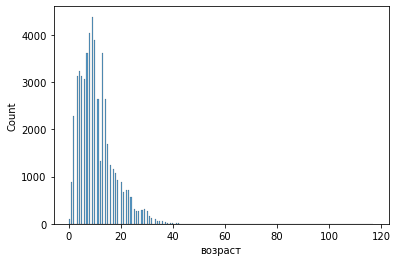

In [44]:
sns.histplot(data['возраст'])

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='возраст'>

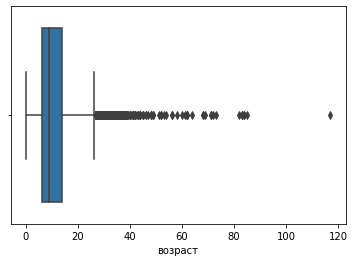

In [45]:
sns.boxplot(data['возраст'])

<AxesSubplot:xlabel='пробег', ylabel='Count'>

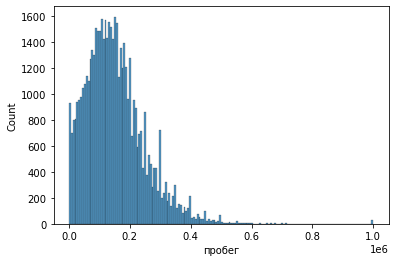

In [46]:
sns.histplot(data['пробег'])

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='пробег'>

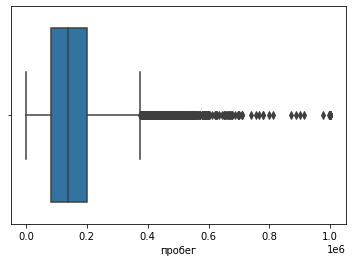

In [47]:
sns.boxplot(data['пробег'])

<AxesSubplot:xlabel='лс', ylabel='Count'>

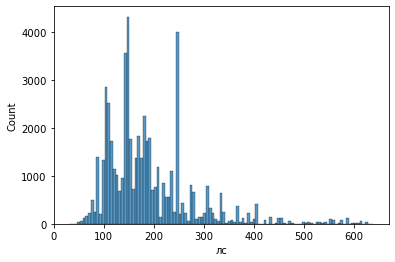

In [48]:
sns.histplot(data['лс'])

<AxesSubplot:xlabel='объем л', ylabel='Count'>

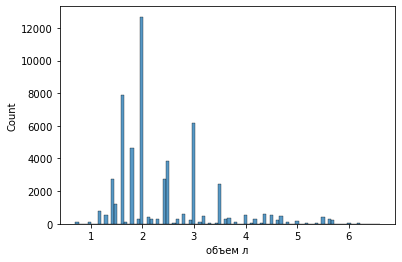

In [49]:
sns.histplot(data['объем л'])

In [50]:
# введем новый показатель пермножением литажа на мощность
data['об*лс'] = data['объем л']*data['лс']

<AxesSubplot:xlabel='об*лс', ylabel='Count'>

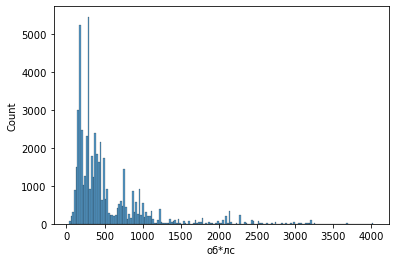

In [51]:
sns.histplot(data['об*лс'])

<AxesSubplot:xlabel='цена', ylabel='Count'>

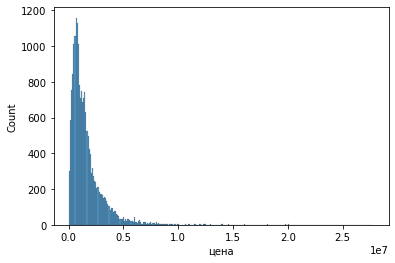

In [52]:
# рассмотрим цены
sns.histplot(df_pars['цена'])

In [53]:
df_pars['цена'].min()

25000

In [54]:
df_pars['цена'].max()

27800000

In [55]:
# проверим реальность не является ли это выбросом
data[data['цена'] == data['цена'].max()]

,кузов,бренд,цвет,топливо,пробег,модель,коробка,ПТС,привод,руль,объем л,лс,цена,train,классиф,возраст,об*лс
52685,минивэн,MERCEDES,чёрный,дизель,100,MERCEDES V,автоматическая,Оригинал,полный,Левый,2.1,190,27800000,1,дорогой сегмент,1,399.0


In [56]:
df_pars[df_pars['цена'] == df_pars['цена'].min()]

,кузов,бренд,цвет,топливо,пробег,модель,год выпуска,sell_id,коробка,ПТС,привод,руль,состояние,таможня,объем л,лс,цена,train
12294,универсал 5 дв.,NISSAN,белый,Бензин,350000,NISSAN PRIMERA,1991,0,механическая,Оригинал,передний,Левый,Не требует ремонта,Растаможен,2.0,115,25000,1
13618,хэтчбек 5 дв.,NISSAN,серый,Бензин,123456,NISSAN BLUEBIRD,1989,0,механическая,Дубликат,передний,Левый,Не требует ремонта,Растаможен,2.0,105,25000,1


Данные в целом распределены почти нормально со смещением. 
Чтобы их сгладить используем логарифмирование.
Цены разнятся очень сильно, но это не выбросы.
Поэтому цены тоже логарифмируем.

In [57]:
# список колонок с количественными показателями
col = ['пробег', 'объем л', 'лс', 'возраст', 'об*лс', 'цена']

In [58]:
data[col].describe()

,пробег,объем л,лс,возраст,об*лс,цена
count,54147.000000,54147.000000,54147.000000,54147.000000,54147.000000,5.414700e+04
mean,151658.184849,2.374490,187.734094,10.716309,513.693773,5.801923e+05
std,97759.670235,0.934151,86.969232,6.892494,482.357658,1.241060e+06
min,1.000000,0.700000,30.000000,0.000000,33.000000,0.000000e+00
25%,82523.000000,1.800000,129.000000,6.000000,210.000000,0.000000e+00
50%,138377.000000,2.000000,170.000000,9.000000,360.000000,0.000000e+00
75%,200000.000000,3.000000,233.000000,14.000000,633.000000,7.490000e+05
max,1000000.000000,6.600000,639.000000,117.000000,4026.000000,2.780000e+07


In [59]:
data[col].corr()

,пробег,объем л,лс,возраст,об*лс,цена
пробег,1.000000,0.014186,-0.183599,0.697114,-0.098911,-0.294488
объем л,0.014186,1.000000,0.836045,0.005821,0.922009,0.157624
лс,-0.183599,0.836045,1.000000,-0.208465,0.942468,0.258652
возраст,0.697114,0.005821,-0.208465,1.000000,-0.101300,-0.340833
об*лс,-0.098911,0.922009,0.942468,-0.101300,1.000000,0.199780
цена,-0.294488,0.157624,0.258652,-0.340833,0.199780,1.000000


    Выводы: все играют важную роль в формировании цены. Есть зависимость между возрастом и пробегом, что понятно 
    и между объемом двигателя и мощностью, что тоже понятно. Но ни один из этих показателей убирать нельзя.

### значимость количественных признаков

In [60]:
col1 = ['пробег', 'объем л', 'лс', 'возраст', 'об*лс']

In [61]:
num = Series(f_regression(data[data['train'] == 1][col1],
                          data[data['train'] == 1]['цена'])[0], index=col1)

<AxesSubplot:>

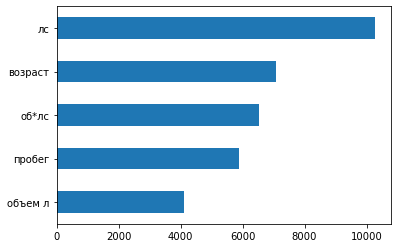

In [62]:
num.sort_values(inplace=True)
num.plot(kind='barh')

In [63]:
data.head()

,кузов,бренд,цвет,топливо,пробег,модель,коробка,ПТС,привод,руль,объем л,лс,цена,train,классиф,возраст,об*лс
0,лифтбек,SKODA,синий,бензин,74000,SKODA OCTAVIA,роботизированная,Оригинал,передний,Левый,1.2,105,0,0,средний,7,126.0
1,лифтбек,SKODA,чёрный,бензин,60563,SKODA OCTAVIA,механическая,Оригинал,передний,Левый,1.6,110,0,0,средний,4,176.0
2,лифтбек,SKODA,серый,бензин,88000,SKODA SUPERB,роботизированная,Оригинал,передний,Левый,1.8,152,0,0,средний,7,273.6
3,лифтбек,SKODA,коричневый,бензин,95000,SKODA OCTAVIA,автоматическая,Оригинал,передний,Левый,1.6,110,0,0,средний,7,176.0
4,лифтбек,SKODA,белый,бензин,58536,SKODA OCTAVIA,автоматическая,Оригинал,передний,Левый,1.8,152,0,0,средний,9,273.6


### нормализация данных и разбивка данных

In [64]:
data1 = data.copy()

In [65]:
# преобразуем числовые переменные через логарифмирование
for i in col[:-1]:
    data1[i] = np.log(data1[i] + 1)

In [66]:
data.columns.values

array(['кузов', 'бренд', 'цвет', 'топливо', 'пробег', 'модель', 'коробка',
       'ПТС', 'привод', 'руль', 'объем л', 'лс', 'цена', 'train',
       'классиф', 'возраст', 'об*лс'], dtype=object)

In [67]:
# разбивка категориальных признаков
data1=pd.get_dummies(data1, columns=['кузов'])
data1=pd.get_dummies(data1, columns=['бренд'])
data1=pd.get_dummies(data1, columns=['цвет'])
data1=pd.get_dummies(data1, columns=['топливо'])
data1=pd.get_dummies(data1, columns=['коробка'])
data1=pd.get_dummies(data1, columns=['ПТС'])
data1=pd.get_dummies(data1, columns=['привод'])
data1=pd.get_dummies(data1, columns=['руль'])
data1=pd.get_dummies(data1, columns=['модель'])
data1=pd.get_dummies(data1, columns=['классиф'])

In [68]:
# для кагла данные для subm
data_test = data1[data1['train'] == 0]
X_sub = data_test.drop('цена', axis=1)

In [69]:
X_sub.shape

(34686, 572)

In [70]:
data_mod = data1[data1['train'] == 1]

In [71]:
Y = data_mod['цена']
X = data_mod.drop('цена', axis=1)

In [72]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.20, random_state=42)

In [73]:
RANDOM_SEED = 42

## модели регрессии

In [74]:
# функция подсчета метрики MAPE
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### 1. модель будстрапа

In [75]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, y_train,
         #cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

In [76]:
predict_test = model.predict(X_test)

In [77]:
print('MAPE', round(mape(y_test, predict_test), 2))

MAPE 12.53


### 2. модель случайного леса

In [78]:
random_grid = {'n_estimators': [int(x) for x in np.linspace(start=100, stop=400, num=4)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(5, 15, num=6)] + [None],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

In [79]:
best_rfr = RandomForestRegressor(random_state=RANDOM_SEED, n_estimators=200, min_samples_split=5,
                                 min_samples_leaf=1, max_features='auto', max_depth=15, bootstrap=True)
best_rfr.fit(X_train, np.log(y_train))

RandomForestRegressor(max_depth=15, min_samples_split=5, n_estimators=200,
                      random_state=42)

In [80]:
predict_rfr = np.exp(best_rfr.predict(X_test))

In [81]:
print('MAPE', round(mape(y_test, predict_rfr), 2))

MAPE 12.33


### 3. модель градиентного бустинга

In [82]:
random_grid = {'n_estimators': [int(x) for x in np.linspace(start=100, stop=400, num=8)],
               'max_features': ['auto', 'sqrt', 'log2'],
               'max_depth': [int(x) for x in np.linspace(5, 15, num=6)] + [None],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4]}

In [83]:
best_gbr = GradientBoostingRegressor(random_state=RANDOM_SEED, n_estimators=400,
                                     min_samples_split=2, min_samples_leaf=4, max_features='auto', max_depth=7)

In [84]:
best_gbr.fit(X_train, np.log(y_train))
predict_gbr = np.exp(best_gbr.predict(X_test))

In [85]:
print('MAPE', round(mape(y_test, predict_gbr), 2))

MAPE 11.61


### 4. модель бэггинг со случайным лесом

In [86]:
bagg_rfr = BaggingRegressor(best_rfr, n_estimators=3, n_jobs=1, random_state=RANDOM_SEED)

In [87]:
bagg_rfr.fit(X_train, np.log(y_train))
predict_bagg_rfr = np.exp(bagg_rfr.predict(X_test))

In [88]:
print('MAPE', round(mape(y_test, predict_bagg_rfr), 2))

MAPE 12.66


### 5. модель бэггинг с градиентным бустингом

In [89]:
bagg_gbr = BaggingRegressor(
    best_gbr, n_estimators=3, n_jobs=1, random_state=RANDOM_SEED)

In [90]:
bagg_gbr.get_params

<bound method BaseEstimator.get_params of BaggingRegressor(base_estimator=GradientBoostingRegressor(max_depth=7,
                                                          max_features='auto',
                                                          min_samples_leaf=4,
                                                          n_estimators=400,
                                                          random_state=42),
                 n_estimators=3, n_jobs=1, random_state=42)>

In [91]:
bagg_gbr.fit(X_train, np.log(y_train))
predict_bagg_gbr = np.exp(bagg_gbr.predict(X_test))

In [92]:
print('MAPE', round(mape(y_test, predict_bagg_gbr), 2))

MAPE 11.68


### 6. метод стэкинг

In [110]:
estimators = [('GB', best_gbr),('RF',best_rfr)]

In [111]:
st_ensemble=StackingRegressor(estimators = estimators, 
                              final_estimator = model)
st_ensemble.fit(X_train, np.log(y_train))
predict_ensemble=np.exp(st_ensemble.predict(X_test))

In [112]:
print('MAPE', round(mape(y_test, predict_ensemble), 2))

MAPE 11.82


### submiting

In [96]:
sample_submission = pd.read_csv('sub.csv')

In [100]:
# самый лучший результат на kaggle - 15.16129
predict_submission2 = np.exp(best_gbr.predict(X_sub))

In [107]:
# корректировка на инфляцию
# мы получили прогноз на сегодня, а тестовая база создана в 2020
# анализ обзоров авторынка позволяет сделать оценку роста цен на 10%
# с учетом дефицита в салонах некоторых марок новых авто беру оценку 12%
predict_submission = predict_submission2/1.12

In [108]:
sample_submission['price'] = predict_submission
sample_submission.to_csv('submit.csv', index=False)
sample_submission.head(5)

,sell_id,price
0,1100575026,678345.404124
1,1100549428,933250.509994
2,1100658222,848260.709052
3,1100937408,691947.887035
4,1101037972,671703.874739
